# Predicting closing price movements of NASDAQ stocks
Code and text done by Attila Jamilov, Cooper Richmond, some code by Yueying Du, Brandon Leong, Josephine Welin.
Text written and improved by Brandon

## Introduction
In the last minutes of the market being open, many stocks see heightened volatility as well as big price fluctuation. NASDAQ stock exchange uses the NASDAQ Closing Cross auction to determine the official closing prices for various assets on their exchange. We want to evaluate the performance of multiple models that we learned in class and not, on predicting this closing price movement using the dataset provided in the [Kaggle](https://www.kaggle.com/competitions/optiver-trading-at-the-close/overview), and see what models performs best, and what features we can engineer to improve on the performance of the models. 

### Project Goal
We evaluate how well different machine learning algorithms can predict stock price movement near the market close. Our specific target is the change in the *market clearing price* during the NASDAQ Closing Cross.

### Data Overview
Each row represents auction-related market activity for a given stock on a given day. For our features, we will try using only the features provided in the dataset, then creating our own original features, trying features that the Kaggle competitors had success with, and finally a compilation of all features. Then, we will select only the most helpful features, and then test our best model on the test data set through the Kaggle. 

### Models and Algorithms
For our models, we will begin with Linear Regression (Josephine), Random Forest (Brandon), LightGBM and CNN (Yueying), XGBoost (Cooper), and finally we will look into Catboost (Attila), a model developed by Yandex which the winner of the Kaggle used for his approach to this Kaggle. We compare all of these models using mean average error. 

## Data Processing
First, we need to import the data: 

In [20]:
# Data processing done by Attila and Cooper
import pandas as pd

def process_data(df: pd.DataFrame):
    df.dropna(subset=["target"], inplace=True)
    X = df.drop(["target"], axis=1)
    y = df["target"]
    return X, y

We also define several processing functions.

The function process_data_drop_null_target removes all rows with missing target values.

The function process_data_drop_prices removes rows with missing near_price or far_price, because some models (linear regression) can't handle null features. 

In [21]:
def process_data_drop_null_target(df: pd.DataFrame):
    df_processed = df.dropna(subset=["target"]).copy()
    X = df_processed.drop(["target"], axis=1)
    y = df_processed["target"]
    return X, y

def process_data_drop_prices(df: pd.DataFrame):
    df_processed = df.dropna(subset=["near_price", "far_price"]).copy()
    X = df_processed.drop(["target"], axis=1)
    y = df_processed["target"]
    return X, y

We create a general training function to handle training multiple models with the same dataset, as well as specialized cases for LightGBM due to early stopping and evaluation.

In [22]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_absolute_error
def train_model(model_class, X_train, y_train, X_val, y_val, params=None):
    if params:
        model = model_class(**params)
    else:
        model = model_class()

    if isinstance(model, LGBMRegressor):
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            callbacks=[
                early_stopping(stopping_rounds=150, verbose=True),
                log_evaluation(period=150)
            ]
        )
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    return mae, model

df = pd.read_csv("./train.csv", index_col="row_id") 

df = df.sample(frac=0.1, random_state=42)

In [23]:
X, y = process_data_drop_null_target(df.copy())

We 'remove' the identifying feature "row_id", but we set it as the `index_col`, which is necessary for submitting to the Kaggle but will not be used as a feature when training the models. 

Next, we need to split the data into a training and validating subsets:

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

`train_test_split` shuffles the data on it's own, therefore there is nothing we need to do on that part. We are done with our initial data processing, but certain models cannot handle NaN values, so individual work will need to be done to get them to work. Now we can move on to Naive model training with the most basic features.

## Naive feature selection

Before doing any feature selection, we will first evaluate our models on the given features, to see how well feature engineering will improve our results.



In [25]:
# Linear Regression
# Original code by Josephine, appended and corrected to work with data to Notebook by Attila, Cooper
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


X_lr, y_lr = process_data_drop_prices(df.copy())
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(X_lr, y_lr, test_size=0.33, random_state=42)
mae_lr, _ = train_model(LinearRegression, X_train_lr, y_train_lr, X_val_lr, y_val_lr)

/Users/cooperrichmond/Code/VSCODE/Python/CFRM 521/conda-env/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/cooperrichmond/Code/VSCODE/Python/CFRM 521/conda-env/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/cooperrichmond/Code/VSCODE/Python/CFRM 521/conda-env/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


Random forest is an ensemble learning method that utilizes decision trees to output average predictions. While easy to tune, training on the full data set was computationally intensive and inefficient due to it's size. Since Random Forest was a core part of our class' material, we included it by training it on a smaller (5%) random sample of the dataset to reduce training time even though it isn't a good fit for what we are trying to achieve.

*Contributed by [Brandon]*


In [26]:
# Random Forest
# Original code by Brandon, appended and corrected to work with data to Notebook by Attila, Cooper
from sklearn.ensemble import RandomForestRegressor

df_rf = df.sample(frac=0.05).copy()
X_rf, y_rf = process_data_drop_null_target(df_rf)
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, test_size=0.33, random_state=42)
rf_params = {"n_estimators": 100, "random_state": 42, "n_jobs": -1}
mae_rf, _ = train_model(RandomForestRegressor, X_train_rf, y_train_rf, X_val_rf, y_val_rf, params=rf_params)

LightGBM (Light Gradient Boosting Machine) is a high-performance gradient boosting framework that is well-suited for large-scale datasets and tabular data with many features. It is particularly efficient for training on millions of observations, which made it a practical choice for our dataset of over 5 million instances.

In [ ]:
# LightGBM
# Original code by Yueying, appended to notebook by Attila, Cooper

lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'n_estimators': 2000,
    'min_child_samples': 50,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'device': 'gpu',
    'random_state': 42,
    'n_jobs': -1
}
mae_lgbm, _ = train_model(LGBMRegressor, X_train, y_train, X_val, y_val, params=lgbm_params)

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3316
[LightGBM] [Info] Number of data points in the train set: 350939, number of used features: 15
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Start t

This code is for training an XGBoost regression model, evaluating it with MAE, and inspecting feature importances. It accepts the training and validation features and target values, along with a list of feature names to use for training. The function configures the model with predefined hyperparameters. These include a squared error objective, mean absolute error (MAE) as the evaluation, a learning rate of 0.05, and a maximum tree depth of 6. After training, it makes predictions and calculates the MAE to determine performance.

In [ ]:
import xgboost

xgb_params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'device': "cuda",
    'random_state': 42
}
mae_xgb, _ = train_model(xgboost.XGBRegressor, X_train, y_train, X_val, y_val, params=xgb_params)

Catboost is the model that was used to win first place in the kaggle. Catboost itself is an algorithm with a novel gradient-boosting scheme on decision trees. It is developed by Yandex, and it has many benefits, such as providing great quality with the default parameters, saving time from parameter tuning, and it supports categorical features, instead of having to pre-process data to numerical values. 

In [ ]:
from catboost import CatBoostRegressor

cb_params = {"loss_function": "MAE", "random_state": 42, "verbose": 1, "task_type": "GPU", "thread_count": -1, "cat_features": ['stock_id', 'imbalance_buy_sell_flag'] }
mae_cb, _ = train_model(CatBoostRegressor, X_train, y_train, X_val, y_val, params=cb_params)

0:	learn: 6.4050494	total: 92.5ms	remaining: 1m 32s
1:	learn: 6.4021959	total: 125ms	remaining: 1m 2s
2:	learn: 6.3997248	total: 156ms	remaining: 51.8s
3:	learn: 6.3973006	total: 186ms	remaining: 46.3s
4:	learn: 6.3948483	total: 218ms	remaining: 43.4s
5:	learn: 6.3924930	total: 247ms	remaining: 40.9s
6:	learn: 6.3905573	total: 274ms	remaining: 38.8s
7:	learn: 6.3886754	total: 305ms	remaining: 37.9s
8:	learn: 6.3866726	total: 343ms	remaining: 37.8s
9:	learn: 6.3848106	total: 374ms	remaining: 37s
10:	learn: 6.3830461	total: 405ms	remaining: 36.4s
11:	learn: 6.3813733	total: 435ms	remaining: 35.8s
12:	learn: 6.3797903	total: 466ms	remaining: 35.3s
13:	learn: 6.3783677	total: 493ms	remaining: 34.7s
14:	learn: 6.3769530	total: 523ms	remaining: 34.3s
15:	learn: 6.3756847	total: 552ms	remaining: 33.9s
16:	learn: 6.3745334	total: 581ms	remaining: 33.6s
17:	learn: 6.3733299	total: 612ms	remaining: 33.4s
18:	learn: 6.3721532	total: 643ms	remaining: 33.2s
19:	learn: 6.3711233	total: 670ms	remaini

### Naive Feature selection model performance
Now that we have trained and predicted each algorithm, we can finally evaluate their performance to give us a baseline to test on:

In [31]:
print(f"Linear Regression: {mae_lr:.4f}")
print(f"Random Forest: {mae_rf:.4f}")
print(f"LightGBM: {mae_lgbm:.4f}")
print(f"XGBoost: {mae_xgb:.4f}")
print(f"CatBoost: {mae_cb:.4f}")

Linear Regression: 5.7078
Random Forest: 6.4020
LightGBM: 6.3044
XGBoost: 6.3004
CatBoost: 6.3020


Interestingly, we found dropping near price and far price (features that are half null), gave Linear Regression the best score. Among the models that trained on the whole training set, LightGBM had the best MAE. This is a good starting point to see how well we can improve the performance of the last three models. To save time and avoid redundancy, we will not pursue Linear Regression or Random Forest further.

## Original Feature Engineering
Contributed by Cooper Richmond

In this section, we will think of and create our own features to use for training the finalist models (LightGBM, XGBoost, and CatBoost). 

These our are originally made features: 

- `wap_volatility`: Measures how much the weighted average price (WAP) swings over 5 time periods for each stock. 

- `bid_ask_spread`: Difference between the selling price (ask) and buying price (bid).

- `bid_ask_volatility`: Tracks how much the bid-ask spread varies over 5 time periods for each stock.

- `wap_momentum`: Shows the percentage change in WAP over 3 time periods for each stock.

- `price_momentum`: Shows the percentage change in reference price over 3 time periods for each stock.

- `log_imbalance_size`: Shrinks large imbalance size values (buy/sell order differences) using a log function.

- `log_matched_size`: Shrinks large matched order size values using a log function.

- `log_bid_size`: Shrinks large bid order size values using a log function.

- `log_ask_size`: Shrinks large ask order size values using a log function.

- `bucket_price_interaction`: Multiplies time (seconds in bucket) by reference price to capture their combined effect.

- `bucket_imbalance_interaction`: Multiplies time (seconds in bucket) by imbalance size to capture their combined effect.

- `wap_to_ref_price`: Divides WAP by reference price to show their relative difference.

- `bid_to_ask_price`: Divides bid price by ask price to show their relative difference.

In [32]:
# Written by Cooper and Attila 
def process_data_with_feature_engineering(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    # Drop rows where 'target' is null, as these cannot be used for training
    data.dropna(subset=["target"], inplace=True)

    # Volatility features
    data['wap_volatility'] = data.groupby('stock_id')['wap'].transform(
        lambda x: x.pct_change().rolling(window=5, min_periods=1).std()
    )
    data['bid_ask_spread'] = data['ask_price'] - data['bid_price']
    data['bid_ask_volatility'] = data.groupby('stock_id')['bid_ask_spread'].transform(
        lambda x: x.rolling(window=5, min_periods=1).std()
    )

    # Momentum features
    data['wap_momentum'] = data.groupby('stock_id')['wap'].transform(
        lambda x: x.pct_change(periods=3)
    )
    data['price_momentum'] = data.groupby('stock_id')['reference_price'].transform(
        lambda x: x.pct_change(periods=3)
    )

    # Log transformations
    size_cols = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']
    for col in size_cols:
        data[f'log_{col}'] = np.log1p(data[col].clip(lower=0))

    # Time-based interactions
    data['bucket_price_interaction'] = data['seconds_in_bucket'] * data['reference_price']
    data['bucket_imbalance_interaction'] = data['seconds_in_bucket'] * data['imbalance_size']

    # Relative price features
    data['wap_to_ref_price'] = data['wap'] / (data['reference_price'] + 1e-6)
    data['bid_to_ask_price'] = data['bid_price'] / (data['ask_price'] + 1e-6)

    # Handle NaN and inf after feature creation
    # Identify columns that are not identifiers or the target
    cols_to_process = [col for col in data.columns if col not in ['stock_id', 'date_id', 'target', 'time_id', 'row_id']]
    data[cols_to_process] = data[cols_to_process].replace([np.inf, -np.inf], np.nan) # Replace inf with NaN first
    data[cols_to_process] = data[cols_to_process].fillna(data[cols_to_process].median()) # Fill remaining NaNs with median

    # Separate features (X) and target (y)
    X = data.drop("target", axis=1)
    y = data["target"]

    return X, y

Now we can redo the naive training but with our original features:

In [ ]:
import numpy as np

X, y = process_data_with_feature_engineering(df.copy())

# Split the data into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# LightGBM
lgbm_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'n_estimators': 2000,
    'min_child_samples': 50,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'device': 'gpu',
    'random_state': 42,
    'n_jobs': -1
}
mae_lgbm, lgbm_model = train_model(LGBMRegressor, X_train, y_train, X_val, y_val, params=lgbm_params)

# XGBoost
xgb_params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'device': "cuda",
    'random_state': 42
}
mae_xgb, xgb_model = train_model(xgboost.XGBRegressor, X_train, y_train, X_val, y_val, params=xgb_params)

# CatBoost
cb_params = {"loss_function": "MAE", "random_state": 42, "verbose": 0, "task_type": "GPU", "thread_count": -1, "cat_features": ['stock_id', 'imbalance_buy_sell_flag']} 
mae_cb, cb_model = train_model(CatBoostRegressor, X_train, y_train, X_val, y_val, params=cb_params)

/var/folders/qr/z2rw3p755gzgwr5bsbt6r5x00000gn/T/ipykernel_47502/2978197467.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  lambda x: x.pct_change().rolling(window=5, min_periods=1).std()
/var/folders/qr/z2rw3p755gzgwr5bsbt6r5x00000gn/T/ipykernel_47502/2978197467.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  lambda x: x.pct_change(periods=3)
/var/folders/qr/z2rw3p755gzgwr5bsbt6r5x00000gn/T/ipykernel_47502/2978197467.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values pr

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6631
[LightGBM] [Info] Number of data points in the train set: 350939, number of used features: 28
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Start t

In [36]:
print(f"LightGBM MAE: {mae_lgbm:.4f}")
print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"CatBoost MAE: {mae_cb:.4f}")


LightGBM MAE: 6.2914
XGBoost MAE: 6.2923
CatBoost MAE: 6.2825


We are seeing some minor improvements, but not enough to justify that our features are that helpful. Let's use the post processing trick that was used by the 1st place winner, and see how those results compare:

We applied the post-processing trick used by the Kaggle first-place solution, which corrects each model’s predictions by subtracting the weighted average prediction for each time_id. The weights are based on a predefined stock_weights dictionary reflecting the relative importance or liquidity of each stock.

*Explanation contributed by [Brandon]*


In [37]:
# Define stock weights (Given by Kaggle) (Attila, Cooper)
weight_df = pd.DataFrame()
weight_df['stock_id'] = list(range(200))
weight_df['weight'] = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,]
stock_weights = dict(zip(weight_df['stock_id'], weight_df['weight']))

In [ ]:
# Brandon Leong - imrpoved and cleaned code to universal helper function for post processing

def apply_postprocessing(model, X_val, y_val, stock_weights, model_name="Model"):
    preds_df = pd.DataFrame({
        'prediction': model.predict(X_val),
        'stock_id': X_val['stock_id'],
        'time_id': X_val['time_id']
    })
    preds_df['stock_weights'] = preds_df['stock_id'].map(stock_weights)
    preds_df['weighted_sum'] = preds_df['prediction'] * preds_df['stock_weights']
    
    weighted_avg = preds_df.groupby('time_id')['weighted_sum'].transform('sum') / preds_df.groupby('time_id')['stock_weights'].transform('sum')
    preds_adjusted = preds_df['prediction'] - weighted_avg
    
    mae_adjusted = mean_absolute_error(y_val, preds_adjusted)
    print(f"{model_name} Adjusted MAE: {mae_adjusted:.4f}\n")
    return preds_adjusted, mae_adjusted

print("--- LightGBM post-processing ---")
y_pred_lgbm_adjusted, mae_lgbm_adjusted = apply_postprocessing(lgbm_model, X_val, y_val, stock_weights, "LightGBM")

print("--- XGBoost post-processing ---")
y_pred_xgb_adjusted, mae_xgb_adjusted = apply_postprocessing(xgb_model, X_val, y_val, stock_weights, "XGBoost")

print("--- CatBoost post-processing ---")
y_pred_cb_adjusted, mae_cb_adjusted = apply_postprocessing(cb_model, X_val, y_val, stock_weights, "CatBoost")

--- LightGBM post-processing ---
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
LightGBM Adjusted MAE: 6.3130

--- XGBoost post-processing ---
XGBoost Adjusted MAE: 6.3160

--- CatBoost post-processing ---
CatBoost Adjusted MAE: 6.3033



Looks like it was helpful to post process only for LightGBM and XGBoost.

## Additional Feature Ideas Inspired by Kaggle Leaderboard
Contributed by Cooper Richmond

This is the code for some features we created that we got the ideas from on the kaggle leaderboard. 

- `seconds_in_bucket_group`: Splits time into three groups: 0 (0-299 seconds), 1 (300-479 seconds), 2 (480+ seconds).  

- `bid_ask_spread`: Difference between ask (sell) and bid (buy) prices.

- `imbalance_ratio`: Divides imbalance size (buy/sell order difference) by matched size (executed orders).

- `mid_price`: Average of ask and bid prices.

- `time_in_auction`: Normalizes time (seconds in bucket) by dividing by 540 to scale between 0 and 1.

We also combined these with our original features into a combined function


In [39]:
# Written by Cooper and Attila 

# Helper functions
def _apply_non_leaderboard_features(data_df: pd.DataFrame) -> pd.DataFrame:
    # Volatility features
    data_df['wap_volatility'] = data_df.groupby('stock_id')['wap'].transform(
        lambda x: x.pct_change().rolling(window=5, min_periods=1).std()
    )
    data_df['bid_ask_spread'] = data_df['ask_price'] - data_df['bid_price']
    data_df['bid_ask_volatility'] = data_df.groupby('stock_id')['bid_ask_spread'].transform(
        lambda x: x.rolling(window=5, min_periods=1).std()
    )

    # Momentum features
    data_df['wap_momentum'] = data_df.groupby('stock_id')['wap'].transform(
        lambda x: x.pct_change(periods=3)
    )
    data_df['price_momentum'] = data_df.groupby('stock_id')['reference_price'].transform(
        lambda x: x.pct_change(periods=3)
    )

    # Log transformations
    size_cols = ['imbalance_size', 'matched_size', 'bid_size', 'ask_size']
    for col in size_cols:
        data_df[f'log_{col}'] = np.log1p(data_df[col].clip(lower=0))

    # Time-based interactions
    data_df['bucket_price_interaction'] = data_df['seconds_in_bucket'] * data_df['reference_price']
    data_df['bucket_imbalance_interaction'] = data_df['seconds_in_bucket'] * data_df['imbalance_size']

    # Relative price features
    data_df['wap_to_ref_price'] = data_df['wap'] / (data_df['reference_price'] + 1e-6)
    data_df['bid_to_ask_price'] = data_df['bid_price'] / (data_df['ask_price'] + 1e-6)

    # Handle NaN and inf for all newly created numerical columns
    # Exclude identifier/target columns as they are handled in the main processing functions
    new_cols_added = [col for col in data_df.columns if col not in ['stock_id', 'date_id', 'target', 'time_id', 'row_id']]
    # Filter to only numerical columns that might contain NaN/inf
    numerical_cols_to_fill = data_df[new_cols_added].select_dtypes(include=np.number).columns
    data_df[numerical_cols_to_fill] = data_df[numerical_cols_to_fill].replace([np.inf, -np.inf], np.nan)
    data_df[numerical_cols_to_fill] = data_df[numerical_cols_to_fill].fillna(data_df[numerical_cols_to_fill].median())

    return data_df

def _apply_leaderboard_features(data_df: pd.DataFrame) -> pd.DataFrame:
    # Handle NaN and infinities in specific input columns first as per original
    input_cols = ['imbalance_size', 'matched_size', 'ask_price', 'bid_price', 'wap', 'reference_price']
    for col in input_cols:
        data_df[col] = data_df[col].replace([np.inf, -np.inf], np.nan).fillna(data_df[col].median())

    # 1st Place: Seconds in bucket group
    data_df['seconds_in_bucket_group'] = np.where(data_df['seconds_in_bucket'] < 300, 0,
                                              np.where(data_df['seconds_in_bucket'] < 480, 1, 2))

    # 9th Place: Basic features
    data_df['bid_ask_spread'] = data_df['ask_price'] - data_df['bid_price']
    data_df['imbalance_ratio'] = data_df['imbalance_size'] / (data_df['matched_size'] + 1e-6)

    # 14th Place: Mid price
    data_df['mid_price'] = (data_df['ask_price'] + data_df['bid_price']) / 2

    # Time in auction
    data_df['time_in_auction'] = data_df['seconds_in_bucket'] / 540

    # Handle NaN and inf for newly created columns
    new_cols = ['seconds_in_bucket_group', 'bid_ask_spread', 'imbalance_ratio', 'mid_price', 'time_in_auction']
    data_df[new_cols] = data_df[new_cols].replace([np.inf, -np.inf], np.nan)
    data_df[new_cols] = data_df[new_cols].fillna(data_df[new_cols].median())

    return data_df


# Main data processing functions
def process_data_non_leaderboard(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df_copy = data.copy()
    # Drop rows where 'target' is null as these cannot be used for training
    df_copy.dropna(subset=["target"], inplace=True)
    df_processed = _apply_non_leaderboard_features(df_copy)

    X = df_processed.drop(["target", "time_id"], axis=1)
    y = df_processed["target"]
    return X, y

def process_data_leaderboard(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df_copy = data.copy()
    # Drop rows where 'target' is null as these cannot be used for training
    df_copy.dropna(subset=["target"], inplace=True)
    df_processed = _apply_leaderboard_features(df_copy)

    X = df_processed.drop(["target", "time_id"], axis=1)
    y = df_processed["target"]
    return X, y

def process_data_combined(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    df_copy = data.copy()
    # Drop rows where 'target' is null as these cannot be used for training
    df_copy.dropna(subset=["target"], inplace=True)

    # Apply non-leaderboard features first
    df_processed = _apply_non_leaderboard_features(df_copy)

    # Apply additional combined features from the leaderboard approach
    # Handle NaN and infinities in specific input columns first as per original combined
    input_cols_combined = ['imbalance_size', 'matched_size', 'ask_price', 'bid_price', 'wap', 'reference_price']
    for col in input_cols_combined:
        df_processed[col] = df_processed[col].replace([np.inf, -np.inf], np.nan).fillna(df_processed[col].median())

    df_processed['seconds_in_bucket_group'] = np.where(df_processed['seconds_in_bucket'] < 300, 0,
                                              np.where(df_processed['seconds_in_bucket'] < 480, 1, 2))
    df_processed['imbalance_ratio'] = df_processed['imbalance_size'] / (df_processed['matched_size'] + 1e-6)
    df_processed['mid_price'] = (df_processed['ask_price'] + df_processed['bid_price']) / 2
    df_processed['time_in_auction'] = df_processed['seconds_in_bucket'] / 540

    # Handle NaN and inf for newly created combined features
    new_cols_combined = ['seconds_in_bucket_group', 'imbalance_ratio', 'mid_price', 'time_in_auction']
    df_processed[new_cols_combined] = df_processed[new_cols_combined].replace([np.inf, -np.inf], np.nan)
    df_processed[new_cols_combined] = df_processed[new_cols_combined].fillna(df_processed[new_cols_combined].median())

    X = df_processed.drop(["target", "time_id"], axis=1)
    y = df_processed["target"]
    return X, y


Now that these functions are defined we can evaluate our models on these features:

In [40]:
X, y = process_data_leaderboard(df.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
mae_lgbm, lgbm_model = train_model(LGBMRegressor, X_train, y_train, X_val, y_val, params=lgbm_params)
mae_xgb, xgb_model = train_model(xgboost.XGBRegressor, X_train, y_train, X_val, y_val, params=xgb_params)
mae_cb, cb_model = train_model(CatBoostRegressor, X_train, y_train, X_val, y_val, params=cb_params)

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3884
[LightGBM] [Info] Number of data points in the train set: 350939, number of used features: 19
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Start t

This gets us the following results:

In [41]:
print(f"LightGBM MAE: {mae_lgbm:.4f}")
print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"CatBoost MAE: {mae_cb:.4f}")

LightGBM MAE: 6.2877
XGBoost MAE: 6.2883
CatBoost MAE: 6.2881


Now we can evaluate on combined features:

In [42]:
X, y = process_data_combined(df.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
mae_lgbm, lgbm_model = train_model(LGBMRegressor, X_train, y_train, X_val, y_val, params=lgbm_params)
mae_xgb, xgb_model = train_model(xgboost.XGBRegressor, X_train, y_train, X_val, y_val, params=xgb_params)
mae_cb, cb_model = train_model(CatBoostRegressor, X_train, y_train, X_val, y_val, params=cb_params)

/var/folders/qr/z2rw3p755gzgwr5bsbt6r5x00000gn/T/ipykernel_47502/2755009002.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  lambda x: x.pct_change().rolling(window=5, min_periods=1).std()
/var/folders/qr/z2rw3p755gzgwr5bsbt6r5x00000gn/T/ipykernel_47502/2755009002.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  lambda x: x.pct_change(periods=3)
/var/folders/qr/z2rw3p755gzgwr5bsbt6r5x00000gn/T/ipykernel_47502/2755009002.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values pr

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6944
[LightGBM] [Info] Number of data points in the train set: 350939, number of used features: 31
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Start t

In [43]:
print(f"LightGBM MAE: {mae_lgbm:.4f}")
print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"CatBoost MAE: {mae_cb:.4f}")

LightGBM MAE: 6.2867
XGBoost MAE: 6.2874
CatBoost MAE: 6.2806


## Parameter Tuning
*Contributed by Brandon Leong*

With this, we can see that CatBoost performs the best out of our finalist models when paired with all of the features. Now to further improve our model's performance, we can begin hypertuning the parameters of the model using RandomizedSearchCV. This allows us to explore a wide range of parameter combinations compared to GridSearch, which is exhaustive but computationally heavy.

In [ ]:
# code by brandon

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# our initial catboost parameters
cb_params = {
    "loss_function": "MAE", 
    "random_state": 42, 
    "verbose": 0, 
    "task_type": "CUDA", 
    "thread_count": -1, 
    "cat_features": ['stock_id', 'imbalance_buy_sell_flag']
} 

# distribution of parameters to try different values for, our what we are tuning
parameter_distributions = {
    'iterations': randint(1000, 3000), # number of trees
    'learning_rate': uniform(0.01, 0.09), # reduces the gradient step, smaller value = more iterations needed
    'depth': randint(4, 10), # tree depth
    'l2_leaf_reg': uniform(1, 10), # regularizer values
    'bagging_temperature': uniform(0, 1), # settings of the Bayesian bootstrap
    'random_strength': uniform(0.1, 1), # amount of randomness to use for scoring splits
    'border_count': randint(32, 255), # number of splits for numerical features
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'] # how trees are grown
}

# catboost model
cat = CatBoostRegressor(
    loss_function="MAE",
    task_type="CUDA",
    thread_count=-1,
    random_state=42,
    cat_features=['stock_id', 'imbalance_buy_sell_flag'],
    verbose=0
)

# use randomized search to find best parameters
search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=parameter_distributions,
    n_iter=40,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

print(f"Best Parameters:{best_model}")

Compared to RandomizedSearchCV, we also have Optuna, a hyperpameter optimization framework suggested to use on the Catboost documentation page. Optuna is generally more efficient and finds better parameters faster. Optuna tries hyperparameters based on past results to focus on promising areas, and supports early stopping allowing us to stop bad trials early. 

In [ ]:
# code by brandon leong
import optuna

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'iterations': 1000,
        'loss_function': 'MAE',
        'task_type': 'CUDA',
        'random_seed': 42,
        'verbose': 0,
        'cat_features': ['stock_id', 'imbalance_buy_sell_flag']
    }

    # train / test splits
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

    # model
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    # predict
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae

# we want to minimize the mae
study = optuna.create_study(direction='minimize')
# 50 trials, can be more for better results
study.optimize(objective, n_trials=50)

print('Best trial:')
best_params = study.best_trial.params
print(best_params)

Now that we have our optimal parameters, we can retrain the model with the best parameters to get out final result.

In [ ]:
best_params.update({
    'loss_function': 'MAE',
    'task_type': 'CUDA',
    'random_seed': 42,
    'verbose': 0,
    'cat_features': ['stock_id', 'imbalance_buy_sell_flag']
})

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train, y_train)

# predict on validation set
final_preds = final_model.predict(X_val)

# get MAE
final_mae = mean_absolute_error(y_val, final_preds)

# results
print(f"Final MAE with best trial params: {final_mae:.4f}")

## Overfitting Exploration
Contributed by Cooper Richmond

This code calculates the training error for your final LightGBM, XGBoost, and CatBoost models by using the already-trained model objects to make predictions on the training data.It makes a line plot that visually compares each model's training error against its validation error, allowing you to easily check for signs of overfitting.

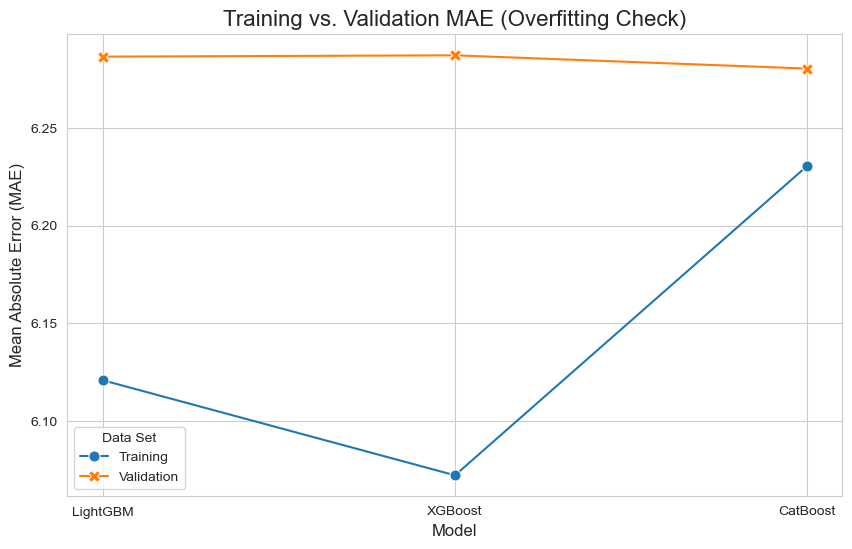

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error

overfitting_data = []
final_models_for_plot = {
    "LightGBM": (lgbm_model, mae_lgbm),
    "XGBoost": (xgb_model, mae_xgb),
    "CatBoost": (cb_model, mae_cb)
}

for model_name, (model_obj, validation_mae) in final_models_for_plot.items():
    y_pred_train = model_obj.predict(X_train)
    training_mae = mean_absolute_error(y_train, y_pred_train)
    overfitting_data.append({'Model': model_name, 'Data Set': 'Training', 'MAE': training_mae})
    overfitting_data.append({'Model': model_name, 'Data Set': 'Validation', 'MAE': validation_mae})

overfitting_df = pd.DataFrame(overfitting_data)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=overfitting_df, x='Model', y='MAE', hue='Data Set', style='Data Set', markers=True, dashes=False, markersize=8)

ax.set_title('Training vs. Validation MAE (Overfitting Check)', fontsize=16)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax.legend(title='Data Set')

plt.grid(True)
plt.show()

Overfitting is what happens when a machine learning model learns the training data too well, including its noise and outliers, which causes the model to perform poorly on new, unseen data.

This chart plots the Mean Absolute Error (MAE) for both the training and validation datasets across three different models: LightGBM, XGBoost, and CatBoost.

Here’s a breakdown of what the chart shows:

X-axis: The machine learning models being compared.

Y-axis: The Mean Absolute Error (MAE). A lower MAE indicates a better performance.

Blue Line (Training MAE): This shows the error of each model on the data it was trained on.

Orange Line (Validation MAE): This shows the error of each model on a separate set of data it has not seen before. This is a better representation of how the model would perform in the real world.

Analysis of the Chart:
Gap between training and validation error: There is a noticeable gap between the training and validation MAE for all three models. The validation error is consistently higher than the training error, which is expected. However, the size of this gap can indicate overfitting.
Performance of the models:
LightGBM and XGBoost: These two models show a larger gap between training and validation error compared to CatBoost. This suggests they generalize worse to new data and are potentially more overfit.

CatBoost: This model has the smallest gap between its training and validation performance. This indicates it is less prone to overfitting on this dataset compared to the other two models.


# Results Analysis
*Improved by Brandon Leong*

Our experiments have shown that the additional features definetely help improve the Mean Absolute Error of the models as features like seconds_in_bucket_group, imbalance_ratio, and mid_price help the models understand different auction phases, supply-demand imbalances, and price centrality which heavily impact how we model price movements. 

Despite having far fewer features and less development time than top leaderboard competitors as well as the top placers on the leaderboard being able to construct over 300 features for this dataset combined with the computing power to quickly test through those data sets, we were able to get relatively good enough results (the difference of MAE from number 1 to us is <1). This showcases the importance of selecting the right model combined with proper feature engineering. If we continued to develop more features and pick which subsets of features worked best we would be able to get good results. Unfortunately we were hit with a time limitation, as the Kaggle ran for over 6 months, while we only had realistically one week.

## Areas of Improvement
*Improved by Brandon Leong*

While our results with our current feature engineering and models have promising results, there a clear areas that we can optimize and refine upon to enhance performance. 

### 1. Handling Missing Data
We could improve upon how we handle the NaN rows of far_price and near_price. As a human, we know that this means that the orders did not fill for the auction, but the models have no way to tell. If we were to find some way to put this in a feature, it might improve the results of the model. Rather than simply dropping the values, creating an indicator to flag for missing migth help with providing better signals over masking patterns in the data.

### 2. Expanded feature Engineering
Another area of improvement would be like previously mentioned, picking the best features and forgetting about other ones that worsen or elongate training time. The winning solution had hundreds of features, and going through each feature to determine the most important and relevant ones could increase accuracy.  

### 3. Model Hyperparameter Tuning
We could also try hyper parameter tuning the other models, as fine tuning hyperparameters such as learning rate, tree depth, number of estimators, regularization terms, and subsampling ratios can lead to significant gains and maybe a different model would rise to have the best results.

### 4. Outside Kaggle Competition
While in regards to the competition, we were supposed to only use the single dataset we were given if we were to continue to refine the model outside of it for real world applicatino, linking external data might help add additional context such as interest rates, CPI, or even news sentiment. Additionally, using other scoring methods such as time series cross validaiton could better reflect everchanging and sequential stock data. 

All of these would be achievable given more time, and we would definitely see some improvement.